In [1]:
import pandas as pd
import numpy as np
import os
from os.path import join as pjoin
import cv2
from scipy import signal

from typing import Dict, Any
import math
from copy import deepcopy

from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm

import torch
from torch import LongTensor, FloatTensor, HalfTensor, Tensor
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
import inspect

from catalyst import dl, utils
import timm

from torch.fft import fft, ifft

from torchaudio.functional import bandpass_biquad
from nnAudio.Spectrogram import CQT1992v2
import torchvision.models as models

def seed_torch(seed=42):
    #random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=42)


%matplotlib inline
def show(img):
    plt.figure(figsize=(10, 10))
    plt.imshow(img.astype(float))
    plt.show()
    
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [25]:
train = pd.read_csv('../kag/g2net-gravitational-wave-detection/training_labels.csv')
train['path'] = train['id'].apply(lambda x: f'../kag/g2net-gravitational-wave-detection//train/{x[0]}/{x[1]}/{x[2]}/{x}.npy')
train['source'] = 'train'

train=train.iloc[:5000]
test = pd.read_csv('../kag/g2net-gravitational-wave-detection/sample_submission.csv')
test['path'] = test['id'].apply(lambda x: f'../kag/g2net-gravitational-wave-detection//test/{x[0]}/{x[1]}/{x[2]}/{x}.npy')
#test['target'] = None
test['source'] = 'test'
test=test.iloc[:5000]

data = train.set_index('id')#.append(test)
data

,target,path,source
id,,,
00000e74ad,1,../kag/g2net-gravitational-wave-detection//tra...,train
00001f4945,0,../kag/g2net-gravitational-wave-detection//tra...,train
0000661522,0,../kag/g2net-gravitational-wave-detection//tra...,train
00007a006a,0,../kag/g2net-gravitational-wave-detection//tra...,train
0000a38978,1,../kag/g2net-gravitational-wave-detection//tra...,train
...,...,...,...
0237d81eb3,0,../kag/g2net-gravitational-wave-detection//tra...,train
0237db8ed4,0,../kag/g2net-gravitational-wave-detection//tra...,train
0237e81f7d,0,../kag/g2net-gravitational-wave-detection//tra...,train


# CrossVal

In [26]:
train_data = data[data['source']=='train'].copy()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_data = []
for fold_train_idx, fold_val_idx in skf.split(train_data, train_data[['source', 'target']].astype(str).apply('_'.join, axis=1)):
    cv_data.append((train_data.iloc[fold_train_idx], train_data.iloc[fold_val_idx]))
len(cv_data), cv_data[0][0].shape, cv_data[0][1].shape

(5, (4000, 3), (1000, 3))

# Dataset

In [27]:
class WaveShiftAug:
    def __init__(self, max_shift_size=20, mode='train'):
        self.max_shift_size = max_shift_size
        self.mode = mode
        
    def __call__(self, waves):
        standart_cut_left = int(self.max_shift_size/2)
        standart_cut_right = -(self.max_shift_size - standart_cut_left)
        cut_waves = waves[:,standart_cut_left: standart_cut_right]
        if self.mode == 'train':
            for i in range(3):
                cut_left = np.random.randint(0, self.max_shift_size)
                cut_right = waves.shape[1]-(self.max_shift_size - cut_left)
                cut_waves[i] = waves[i, cut_left: cut_right]
        return cut_waves 
    
shift_aug_train = WaveShiftAug(max_shift_size=30, mode='train')
shift_aug_test = WaveShiftAug(max_shift_size=30, mode='test')

In [28]:
def wave_abs_norm(input):
    return input / np.max(np.abs(input), 1)[:, None]


class G2netDataset(Dataset):
    def __init__(
        self,
        path,
        target=None,
        idx=None,
        use_mix_up=False,
        chance_of_mixup=0,
        chance_of_mixup_soft_over_hard=0,
        alpha=0,
        shift_aug=None,
        noise=False,
        bandpass_dict = {}
    ):
        self.path = np.array(path)
        if target is not None:
            self.target = FloatTensor(np.array(target))
        else:
            self.target = None
        self.index = idx
        self.use_mix_up = use_mix_up
        self.chance_of_mixup = chance_of_mixup
        self.chance_of_mixup_soft_over_hard = chance_of_mixup_soft_over_hard
        self.alpha = alpha
        self.shift_aug = shift_aug
        self.noise = noise
        self.bandpass_dict = bandpass_dict
        
    def _bandpass(self, x, sr=2048):
        lf = self.bandpass_dict.get("lf", 20)
        hf = self.bandpass_dict.get("hf", 500)
        order = self.bandpass_dict.get("order", 8)

        sos = signal.butter(order, [lf, hf], btype="bandpass", output="sos", fs=sr)
        normalization = np.sqrt((hf - lf) / (sr / 2))
        window = signal.tukey(4096, 0.1)
        if x.ndim == 2:
            x *= window
            for i in range(3):
                x[i] = signal.sosfilt(sos, x[i]) * normalization
        elif x.ndim == 3:  # batch
            for i in range(x.shape[0]):
                x[i] *= window
                for j in range(3):
                    x[i, j] = signal.sosfilt(sos, x[i, j]) * normalization
        return x

    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, idx):
        wave = np.load(self.path[idx])
        if self.target is not None:
            target = self.target[idx]

        if self.shift_aug is not None:
            wave = self.shift_aug(wave)

        wave = wave_abs_norm(wave)
        if (self.use_mix_up) & (np.random.binomial(n=1, p=self.chance_of_mixup)):
            mixup_idx = np.random.randint(0, self.__len__())
            mixup_wave = np.load(self.path[mixup_idx])
            if self.shift_aug is not None:
                mixup_wave = self.shift_aug(mixup_wave)
            mixup_wave = wave_abs_norm(mixup_wave)
            mixup_target = self.target[mixup_idx]
            if np.random.binomial(n=1, p=self.chance_of_mixup_soft_over_hard):
                lam = np.random.beta(self.alpha, self.alpha)
                wave = wave * lam + (1.0 - lam) * mixup_wave
                target = target * lam + (1.0 - lam) * mixup_target
            else:
                wave = wave + mixup_wave
                target = max(target, mixup_target)

        if self.noise:
            if np.random.binomial(n=1, p=self.noise):
                wave = wave + np.random.normal(0, 0.02, len(wave[0]) * 3).reshape(3, -1)

        wave = wave_abs_norm(wave)

        wave = self._bandpass(wave)

        sample = {"features": FloatTensor(wave)}
        if self.target is not None:
            sample["targets"] = target.round()
            sample["mix_targets"] = target

        return sample




def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)


In [29]:
A = G2netDataset(
                    train_data["path"],
                    train_data["target"],
                    train_data.index,
                    use_mix_up=True,
                    chance_of_mixup=0.7,
                    chance_of_mixup_soft_over_hard=0.2,
                    alpha=3,
                    shift_aug=None,
                    noise=0.02,
                )

In [30]:
A[0]['features'].shape

torch.Size([3, 4096])

# Model

In [31]:
SIG_LEN = 2048 * 2
SR = 2048
EPSILON_FP16 = np.finfo(np.float16).eps


def whiten(signal):
    hann = torch.hann_window(SIG_LEN, periodic=True).to(signal.device)
    spec = fft(signal.float() * hann)
    mag = torch.sqrt(torch.real(spec * torch.conj(spec)))

    return torch.real(ifft(spec / mag)) * math.sqrt(SIG_LEN / 2)

from torchaudio.functional import bandpass_biquad

def butter_bandpass_filter(
    input, lowcut, highcut, Q=None, result_padding: int = 0
):
    if Q is None:
        Q = (highcut - lowcut) / (highcut + lowcut)
    output = bandpass_biquad(input, SR, (highcut + lowcut) / 2, Q=Q)
    if result_padding > 0:
        output = output[:, result_padding:]
        output = output[:, :-result_padding]
    return output




class FeautureExtractorNet(nn.Module):
    def __init__(self, type: str, config: Dict[str, Any]):
        super().__init__()

        temp_config = deepcopy(config)
        if type == "CQT1992v2":
            CQT1992v2_params = inspect.signature(
                CQT1992v2.__init__
            ).parameters.keys()
            config_params = list(temp_config.keys())
            for k in config_params:
                if k not in CQT1992v2_params:
                    temp_config.pop(k)
            self.fe_block = CQT1992v2(**temp_config)
        else:
            raise ValueError("Incorrect FeautureExtractorNet type")

        self.config = config

    def forward(self, x):
        if self.config.get("merge_first_dims", False):
            bs, ch, time_dim = x.shape
            x = x.reshape(bs * ch, time_dim)
            if self.config.get("use_whiten", False):
                x = whiten(x)
            if self.config.get("use_bandpass", False):
                x = butter_bandpass_filter(
                    input=x,
                    lowcut=self.config,
                    highcut=self.config.get("highcut", 500),
                    Q=self.config.get("Q", None),
                    result_padding=self.config.get("filter_padding", 0),
                )
                x = x / (x.abs().max(1).values.unsqueeze(1) + EPSILON_FP16)
            x = self.fe_block(x)
            _, freq_dim, time_dim = x.shape
            x = x.reshape(bs, ch, freq_dim, time_dim)
        else:
            x = self.fe_block(x)

        return x

In [32]:
class GeM(nn.Module):
    '''
    Code modified from the 2d code in
    https://amaarora.github.io/2020/08/30/gempool.html
    '''
    def __init__(self, kernel_size=8, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.kernel_size = kernel_size
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool1d(x.clamp(min=eps).pow(p), self.kernel_size).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'
    
class CNN1d(nn.Module):
    """1D convolutional neural network. Classifier of the gravitational waves.
    Architecture from there https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.120.141103
    """

    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d(3, 64, kernel_size=64),
            nn.BatchNorm1d(64),
            nn.SiLU(),
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=32),
            GeM(kernel_size=8),
            nn.BatchNorm1d(64),
            nn.SiLU(),
        )
        self.cnn3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=32),
            nn.BatchNorm1d(128),
            nn.SiLU(),
        )
        self.cnn4 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=16),
            GeM(kernel_size=6),
            nn.BatchNorm1d(128),
            nn.SiLU(),
        )
        self.cnn5 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=16),
            nn.BatchNorm1d(256),
            nn.SiLU(),
        )
        self.cnn6 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=16),
            GeM(kernel_size=4),
            nn.BatchNorm1d(256),
            nn.SiLU(),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 11, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.25),
            nn.SiLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.25),
            nn.SiLU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(64, 1),
        )

    def forward(self, x, pos=None):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = self.cnn5(x)
        x = self.cnn6(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


In [33]:
class TimmModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.wave_model = CNN1d()
        #self.img_model = timm.create_model('tf_efficientnet_b0_ns', pretrained=True)
        #self.img_model.conv_stem.stride = (1,2)
        #self.classifier = nn.Sequential(nn.ELU(), nn.Dropout(0.2), nn.Linear(in_features=1000, out_features=1))
        self.classifier = nn.Identity()
        
    def forward(self, features):
        return self.classifier(self.wave_model(features)).flatten()

In [34]:
m = TimmModel()
d = DataLoader(G2netDataset(train_data['path'], train_data['target'], train_data.index), batch_size=32)
for bach in d:
    break
    
    
out = m(bach['features'])

# Prediction func

In [35]:
def predict_loader(model, runner, loader):
    #pred = runner.predict_loader(model=model, loader=loader)
    pred = []
    for batch in tqdm(loader):
        pred.append(model(batch["features"].to("cuda")).detach().cpu().float().numpy())
        
    print(len(loader), len(pred))
    #pred = [torch.sigmoid(batch['logits'].detach().cpu().float()).numpy() for batch in tqdm(pred)] 
    #pred = [batch['logits'].detach().cpu().float().numpy() for batch in tqdm(pred)] 
    pred = pd.Series(np.concatenate(pred, 0), index = loader.dataset.index)
    return pred


def write_prediction(pred, name, exp_path='logs'):
    sub = pd.read_csv('./sample_submission.csv').set_index('id')
    sub['target'] = pred
    sub.to_csv(f'{exp_path}/sub_{name}.csv')
    

    
def get_valid_logs(exp_path='logs'):
    valid_log = pd.read_csv(f'{exp_path}/logs/valid.csv')#.set_index('step')
    if ('step' == valid_log['step']).any():
        valid_log = valid_log.iloc[valid_log[valid_log['step'] == 'step'].index.max()+1:].reset_index(drop=True)
    return valid_log


def get_sva_model(model, n_sva, exp_path='logs'):
    valid_log = get_valid_logs(exp_path)
    svm_steps = valid_log.sort_values('auc', ascending=False)['step'][:n_sva].to_numpy()
    
    model_state_dict = torch.load(f'{exp_path}/checkpoints/train.{svm_steps[0]}.pth', map_location='cpu')['model_state_dict']
    for key in model_state_dict:
        model_state_dict[key] = model_state_dict[key]/len(svm_steps)

    for step in svm_steps[1:]:
        model_state_dict_i = torch.load(f'{exp_path}/checkpoints/train.{step}.pth', map_location='cpu')['model_state_dict']
        for key in model_state_dict:
            model_state_dict[key] = model_state_dict[key] + model_state_dict_i[key]/len(svm_steps)
            
            
    model.load_state_dict(model_state_dict)
    model = model.eval().cuda()
    return model



def create_model_prediction(model, runner, test_dataloader, valid_loader, exp_path='logs'):
    # BEST
    model.load_state_dict(torch.load(f'{exp_path}/checkpoints/best.pth')['model_state_dict'])
    model = model.eval().cuda()
    score = get_valid_logs(exp_path)['auc'].max()
    pred = predict_loader(model, runner, test_dataloader)
    write_prediction(pred, f'best_{score}', exp_path)


    # SVA 3
    model = get_sva_model(model, 3, exp_path)
    pred = predict_loader(model, runner, valid_loader)
    score = roc_auc_score(valid_loader.dataset.target.numpy(), pred)
    pred.to_csv(f'{exp_path}/valid_pred_swa3_{score}.csv')
    print(f'sva3 score: {score}')

    pred = predict_loader(model, runner ,test_dataloader)
    write_prediction(pred, f'swa3_{score}', exp_path)
    
def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

# EXPERIMENT

In [36]:
!nvidia-smi

Sat Oct  2 23:04:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.80       Driver Version: 460.80       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000001:00:00.0 Off |                    0 |
| N/A   26C    P0    36W / 250W |   1459MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [38]:
EXP_PATH = "conv1d_baseline_public_banpass_lr_1e-4_no_augs"

if True:
    for i, (fold_train, fold_val) in enumerate(cv_data):
        print("Fold", i)
        FOLD_PATH = f"{EXP_PATH}/fold_{i}"
        batch_size = 2

        loaders = {
            "train": DataLoader(
                G2netDataset(
                    fold_train["path"],
                    fold_train["target"],
                    fold_train.index,
                    use_mix_up=True,
                    chance_of_mixup=0.7,
                    chance_of_mixup_soft_over_hard=0.2,
                    alpha=3,
                    shift_aug=None,
                    noise=0.02,
                ),
                worker_init_fn=worker_init_fn,
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=4,
                pin_memory=True,
            ),
            "valid": DataLoader(
                G2netDataset(
                    fold_val["path"], fold_val["target"], fold_val.index, shift_aug=None
                ),
                worker_init_fn=worker_init_fn,
                batch_size=batch_size,
                shuffle=False,
                drop_last=False,
                num_workers=4,
                pin_memory=True,
            ),
        }
        test_dataloader = DataLoader(
            G2netDataset(
                data[data["source"] == "test"]["path"],
                idx=data[data["source"] == "test"].index,
                shift_aug=shift_aug_test,
            ),
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=4,
            pin_memory=False,
        )

        model = TimmModel()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.BCEWithLogitsLoss()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", patience=0, factor=0.3, min_lr=1e-5
        )

        callbacks = [
            dl.AUCCallback(
                input_key="logits",
                target_key="targets",
            ),
            dl.OptimizerCallback("loss"),
            dl.SchedulerCallback(loader_key="valid", metric_key="auc", mode="epoch"),
            dl.CheckpointCallback(
                loader_key="valid",
                metric_key="auc",
                minimize=False,
                save_n_best=5,
                mode="model",
                use_runner_logdir=True,
                use_logdir_postfix=True,
            ),
            dl.EarlyStoppingCallback(
                patience=3, loader_key="valid", metric_key="auc", minimize=False
            ),
            dl.TimerCallback(),
        ]
        runner = dl.SupervisedRunner(
            input_key="features",
            target_key="mix_targets",
            output_key="logits",
            loss_key="loss",
        )
        runner.train(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            loaders=loaders,
            num_epochs=30,
            callbacks=callbacks,
            logdir=f"{FOLD_PATH}",
            #loggers={
            #    "wandb": dl.WandbLogger(project="g2net_comp", name=f"{EXP_PATH}/fold_{i}")
            #},
            valid_loader="valid",
            valid_metric="auc",
            minimize_valid_metric=False,
            verbose=True,
            load_best_on_end=True,
            amp=True,
        )
        create_model_prediction(model, runner, test_dataloader, loaders["valid"], FOLD_PATH)


Fold 0


1/30 * Epoch (train):   0%|          | 0/2000 [00:00<?, ?it/s]

Keyboard Interrupt


KeyboardInterrupt: 

In [15]:
from os import listdir
from scipy.special import expit
from scipy.stats import rankdata

subs = [[f'{EXP_PATH}/fold_{i}/{el}' for el in listdir(f'{EXP_PATH}/fold_{i}') if el[:8]== 'sub_swa3'][0] for i in range(5)]
subs = [pd.read_csv(s).set_index('id')['target'] for s in subs]
subs = pd.concat(subs, axis=1)
subs.columns = list(range(subs.shape[1]))
subs.to_csv(f'{EXP_PATH}/cv_predictions.csv')
subs.corr()

,0,1,2,3,4
0,1.000000,0.980192,0.980231,0.981263,0.981693
1,0.980192,1.000000,0.979160,0.980238,0.978071
2,0.980231,0.979160,1.000000,0.983804,0.982557
3,0.981263,0.980238,0.983804,1.000000,0.982479
4,0.981693,0.978071,0.982557,0.982479,1.000000


In [19]:
subs

,0,1,2,3,4
id,,,,,
00005bced6,5.898563,6.014882,6.706985,5.723432,5.948482
0000806717,3.616365,2.457107,3.677650,3.743128,4.833555
0000ef4fe1,-0.629154,-1.564150,-1.154669,-1.119267,-0.578002
00020de251,0.521323,1.201788,-0.234447,-1.078352,0.064129
00024887b5,-1.923632,-2.072548,-2.075179,-2.037312,-1.757527
...,...,...,...,...,...
ffff4125f1,-0.696808,-0.839005,-1.445363,-1.064602,-0.971482
ffff9d32a6,-0.690260,-1.371823,-1.099668,-1.394595,-0.485392
ffff9f4c1f,-0.868156,-0.909382,-1.147377,-0.792241,-1.097191


In [16]:
sub_logits = subs.mean(axis=1)
sub_logits = expit(sub_logits)

write_prediction(sub_logits, EXP_PATH+'cv_logist_probs', EXP_PATH)

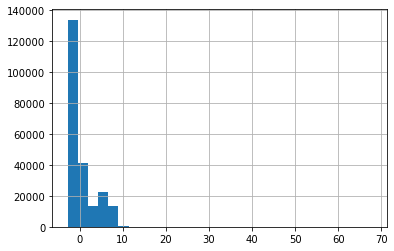

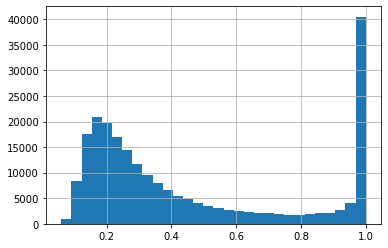

<AxesSubplot:>

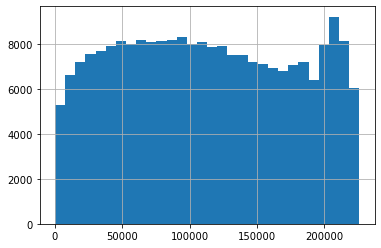

In [17]:
sub_logits = subs.mean(axis=1)
sub_probs = expit(subs).mean(axis=1)
sub_rankdata = subs.apply(rankdata).mean(axis=1)


write_prediction(sub_logits, EXP_PATH+'cv_logits', EXP_PATH)
write_prediction(sub_probs, EXP_PATH+'cv_probs', EXP_PATH)
write_prediction(sub_rankdata, EXP_PATH+'cv_rankdata', EXP_PATH)

%matplotlib inline
sub_logits.hist(bins=30)
plt.show()
sub_probs.hist(bins=30)
plt.show()
sub_rankdata.hist(bins=30)

<AxesSubplot:>

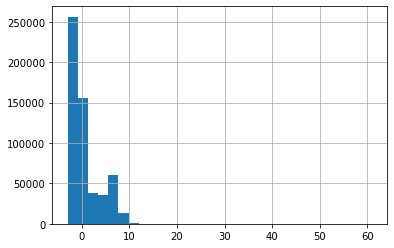

In [18]:
val_oof_pred = [[f'{EXP_PATH}/fold_{i}/{el}' for el in listdir(f'{EXP_PATH}/fold_{i}') if el[:15]== 'valid_pred_swa3'][0] for i in range(5)]
val_oof_pred = [pd.read_csv(pred).set_index('id')['0'] for pred in val_oof_pred]
val_oof_pred = pd.concat(val_oof_pred, axis=0).sort_index()
val_oof_pred.to_csv(f'{EXP_PATH}/valid_oof_prediction.csv')
val_oof_pred.hist(bins=30)